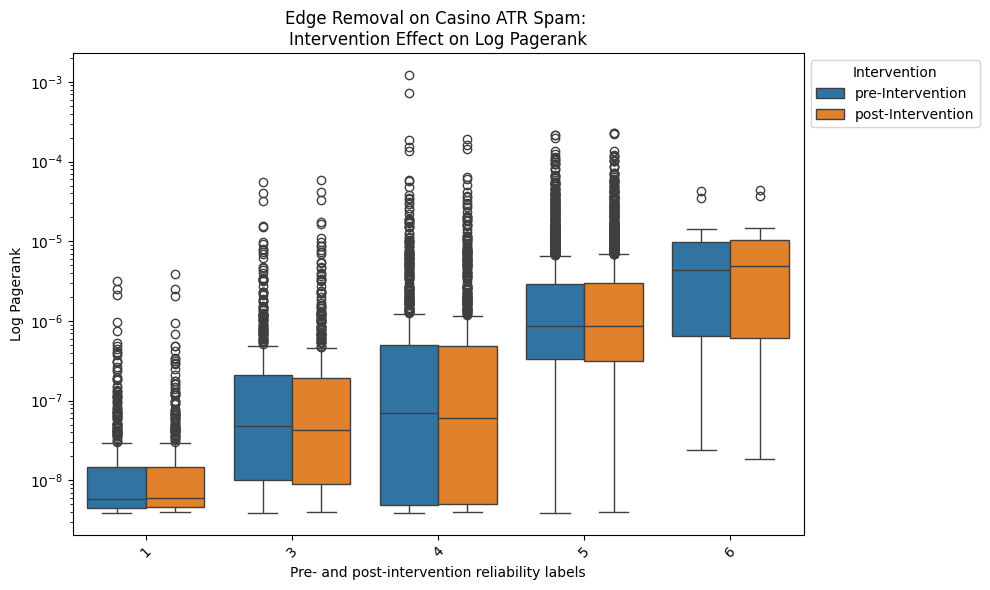

Mann-Whitney U test p-value for group 1: [2.36668338e-79]
Mann-Whitney U test p-value for group 3: [1.5643903e-16]
Mann-Whitney U test p-value for group 4: [1.9719028e-14]
Mann-Whitney U test p-value for group 5: [7.32493164e-77]
Mann-Whitney U test p-value for group 6: [3.64181244e-05]
Kruskal-Wallis H test p-value: [0.57668795]


In [86]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
import numpy as np

def reverse_url(url):
    components = str(url).split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

def plot_pre_post_dists(exp_name, post_file, metric="pagerank_centrality", pre_file='output/ranks/exp-baseline.label_only.out'):
    domain_labels = pd.read_csv('../../data/attributes.csv')[['url', 'label']]
    cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]
    
    # Read pre and post rankings data
    pre_rankings = pd.read_csv(pre_file, sep='\t', names=cc_rank_cols)
    post_rankings = pd.read_csv(post_file, sep='\t', names=cc_rank_cols)
    pre_rankings['url'] = pre_rankings['url'].apply(reverse_url)
    post_rankings['url'] = post_rankings['url'].apply(reverse_url)


    # Filter columns
    pre_rankings = pre_rankings.iloc[:, :-1]  # Drop last column
    post_rankings = post_rankings.iloc[:, :-1]  # Drop last column

    # Merge with domain labels data
    pre_rankings_filtered = pre_rankings.merge(domain_labels, on='url', how='inner')
    post_rankings_filtered = post_rankings.merge(domain_labels, on='url', how='inner')

    beforepr = pre_rankings_filtered[['url', 'label', metric]].assign(Intervention=0)
    afterpr = post_rankings_filtered[['url', 'label', metric]].assign(Intervention=1)

    # Combine dataframes
    longpr = pd.concat([beforepr, afterpr], ignore_index=True)
    longpr['label'] = pd.Categorical(longpr['label'])

    longpr['Intervention_Group'] = longpr['Intervention'].apply(lambda x: 'pre-Intervention' if x == 0 else 'post-Intervention')
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=metric, hue='Intervention_Group', data=longpr)#, showfliers=False)
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.title(f'{exp_name}: \nIntervention Effect on Log Pagerank')
    plt.xlabel('Pre- and post-intervention reliability labels')
    plt.ylabel('Log Pagerank')
    plt.legend(title='Intervention', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Example data (replace with your actual data)
    pre_intervention_data = pre_rankings_filtered[[metric]]
    post_intervention_data = post_rankings_filtered[[metric]]
    assert(set(post_rankings_filtered['url'].tolist()) == set(pre_rankings_filtered['url'].tolist()))
    group_labels = pre_rankings_filtered['label']

    # Perform Mann-Whitney U test for each group
    for label in np.unique(group_labels):
        group_pre = pre_intervention_data[group_labels == label]
        group_post = post_intervention_data[group_labels == label]
        _, p_value = mannwhitneyu(group_pre, group_post)
        print(f"Mann-Whitney U test p-value for group {label}: {p_value}")

    # Perform Kruskal-Wallis H test
    _, p_value = kruskal(pre_intervention_data, post_intervention_data)
    print(f"Kruskal-Wallis H test p-value: {p_value}")
    
    
    beforepr = beforepr.rename(columns={metric:metric+'_orig'}).drop(columns=['label', 'Intervention'])
    afterpr = afterpr.rename(columns={metric:metric+'_inter'}).drop(columns=['label', 'Intervention'])
    return beforepr.merge(right=afterpr, on='url', how='inner')
    
    # Group means/medians
    group_means = longpr.groupby(['Intervention', 'label'])[metric].mean()
    group_medians = longpr.groupby(['Intervention', 'label'])[metric].median()


intervention_exps = [
    # ('PPR on Reliable News', 'output/ranks/exp-rel-ppr.label_only.out'),
    # ('Inv-PPR on Unreliable News', 'output/ranks/exp-unrel-ppr-down.label_only.out'),
    # ('Inv-PPR on Link Schemes', 'output/ranks/exp-ls-ppr-down.label_only.out'),
    # ('Inv-PPR on Anti-TrustRank Spam', 'output/ranks/exp-ls-str-ppr-down.label_only.out'),
    # ('Edge Removal on Link Schemes', 'output/ls_filtered/ls_filtered-ranks.label_only.txt'),
    # ('Edge Removal on Anti-TrustRank Spam', 'output/ls_atr_filtered/ls_atr_filtered-ranks.label_only.txt'),
    # ('Edge Removal on Link Schemes & Anti-TrustRank Spam', 'output/ls_combined_filtered/ls_combined_filtered-ranks.label_only.txt'),
    ('Edge Removal on Casino ATR Spam','output/ls_multi_domain_atr/ls_multi_domain_atr-ranks.label_only.txt'),
]    
    
# "harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality",
for (exp_name, post_file) in intervention_exps:
    plot_pre_post_dists(exp_name, post_file, "pagerank_centrality")#, pre_file='output/ls_atr_filtered/ls_atr_filtered-ranks.label_only.txt')

/tmp/ipykernel_4111330/3660135278.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  post_data = pd.concat([post_data, post_data_exp], ignore_index=True)


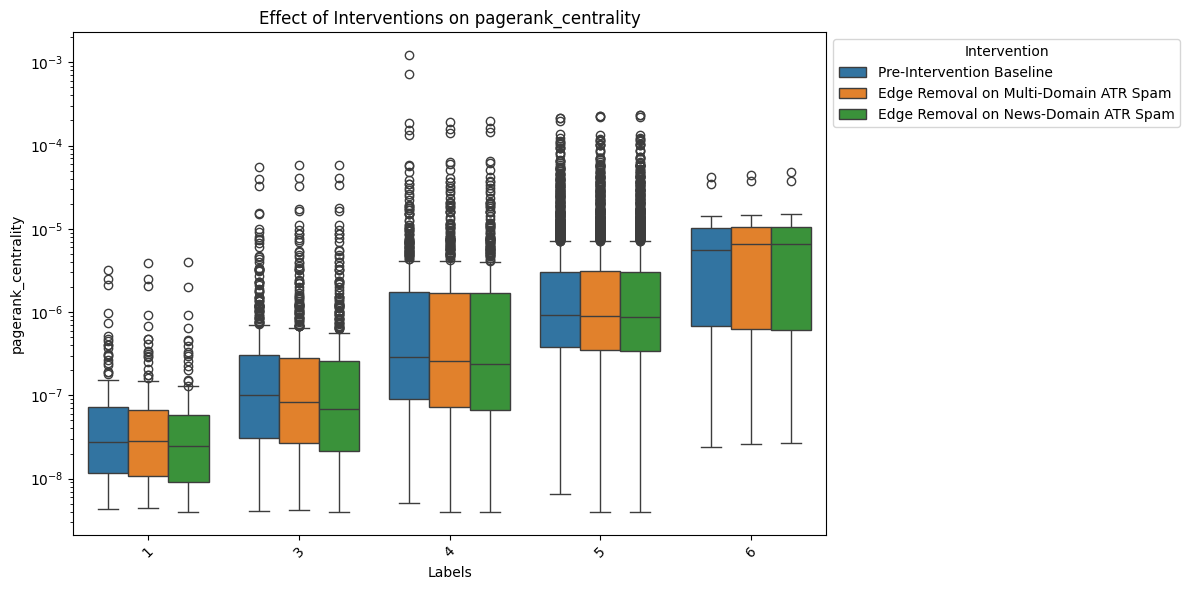

In [101]:
def plot_all_interventions(exp_names, post_files, metric="pagerank_centrality"):
    domain_labels = pd.read_csv('../../data/attributes_3k.csv')[['url', 'label']]
    cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]

    # Create a dictionary to store post intervention data for each experiment
    post_rankings_filtered = {}
    for exp_name, post_file in zip(exp_names, post_files):
        post_rankings = pd.read_csv(post_file, sep='\t', names=cc_rank_cols)
        post_rankings['url'] = post_rankings['url'].apply(reverse_url)
        post_rankings_filtered[exp_name] = post_rankings.merge(domain_labels, on='url', how='inner')

    # Prepare post-intervention data for each experiment
    post_data = pd.DataFrame(columns=['url', 'label', metric, 'Intervention'])
    for exp_name, post_rankings in post_rankings_filtered.items():
        post_data_exp = post_rankings[['url', 'label', metric]].assign(Intervention=exp_name)
        post_data = pd.concat([post_data, post_data_exp], ignore_index=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y=metric, hue='Intervention', data=post_data, showfliers=True)
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.title(f'Effect of Interventions on {metric}')
    plt.xlabel('Labels')
    plt.ylabel(metric)
    plt.legend(title='Intervention', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../fig/pr_reduction_distribution_multi_domain.png')
    plt.show()
    
    
    

intervention_exps = [
    # ('PPR on Reliable News', 'output/ranks/exp-rel-ppr-ranks.label_only.txt'),
    # ('Pre-Intervention Baseline','output/ranks/exp-baseline.label_only.out'),
    # ('Inv-PPR on Link Schemes', 'output/ranks/exp-ls-ppr-down.label_only.out'),
    # ('Inv-PPR on Anti-TrustRank Spam', 'output/ranks/exp-ls-str-ppr-down.label_only.out'),
    # ('Inv-PPR on Unreliable News', 'output/ranks/exp-unrel-ppr-down.label_only.out'),
    # ('Edge Removal on Link Schemes', 'output/ls_filtered/ls_filtered-ranks.label_only.txt'),
    # ('Edge Removal on Anti-TrustRank Spam', 'output/ls_atr_filtered/ls_atr_filtered-ranks.label_only.txt'),
    # ('Edge Removal on Anti-TrustRank Multi-Domain Spam', 'output/ls_multi_domain_atr_combined/ls_multi_domain_atr_combined-ranks.label_only.txt'),
    
    ('Pre-Intervention Baseline','output/ranks/exp-baseline.label_only.out'),
    ('Edge Removal on Multi-Domain ATR Spam','output/ls_multi_domain_atr/ls_multi_domain_atr-ranks.label_only.txt'),
    ('Edge Removal on News-Domain ATR Spam', 'output/ls_combined_filtered/ls_combined_filtered-ranks.label_only.txt'),
]

# Extract experiment names and post intervention files
exp_names = [exp_name for exp_name, _ in intervention_exps]
post_files = [post_file for _, post_file in intervention_exps]

# Plot all interventions
plot_all_interventions(exp_names, post_files, "pagerank_centrality")


In [79]:
def pre_post_ris(exp_name, post_file, metric="pagerank_centrality", pre_file='output/ranks/exp-baseline.label_only.out'):
    domain_labels = pd.read_csv('../../data/attributes.csv')[['url', 'label']]
    domain_labels['label'] = domain_labels['label'].apply(lambda x: x+2 if x == 1 else (x - 1 if x == 6 else x))
    cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]
    
    # Read pre and post rankings data
    pre_rankings = pd.read_csv(pre_file, sep='\t', names=cc_rank_cols)
    post_rankings = pd.read_csv(post_file, sep='\t', names=cc_rank_cols)
    pre_rankings['url'] = pre_rankings['url'].apply(reverse_url)
    post_rankings['url'] = post_rankings['url'].apply(reverse_url)

    # Merge with domain labels data
    pre_post_stats_df = pre_rankings.merge(post_rankings, on='url', how='inner', suffixes=('_orig', '_inter'))[['url', metric + '_orig', metric + '_inter']]
    pre_post_stats_df = pre_post_stats_df.merge(domain_labels[['url','label']], on='url', how='inner')
    pre_post_stats_df['PR'] = pre_post_stats_df[metric + '_inter'] / pre_post_stats_df[metric + '_orig']
    pre_post_stats_df['PI'] = pre_post_stats_df[metric + '_orig'] / pre_post_stats_df[metric + '_inter']
    # 1 - (post_rankings_filtered[metric] - pre_rankings_filtered[metric]) / post_rankings_filtered[metric]
    return pre_post_stats_df[['PR','PI','label']]#.groupby('label').mean()

intervention_exps = [
    ('PPR on Reliable News', 'output/ranks/exp-rel-ppr-ranks.label_only.txt'),
    ('Inv-PPR on Unreliable News', 'output/ranks/exp-unrel-ppr-down.label_only.out'),
    ('Inv-PPR on Link Schemes', 'output/ranks/exp-ls-ppr-down.label_only.out'),
    ('Inv-PPR on Anti-TrustRank', 'output/ranks/exp-ls-str-ppr-down.label_only.out'),
    ('Edge Removal on Link Schemes', 'output/ls_filtered/ls_filtered-ranks.label_only.txt'),
    ('Edge Removal on Anti-TrustRank', 'output/ls_atr_filtered/ls_atr_filtered-ranks.label_only.txt'),
    ('Edge Removal on Multi-Category ATR','output/ls_multi_domain_atr/ls_multi_domain_atr-ranks.label_only.txt'),
    # ('Edge Removal on Multi-Category ATR + Link Schemes', 'output/ls_multi_domain_atr_combined/ls_multi_domain_atr_combined-ranks.label_only.txt'),
    
    # ('Pre-Intervention Baseline','output/ranks/exp-baseline.label_only.out'),
    # ('Edge Removal on News-Domain ATR Spam', 'output/ls_combined_filtered/ls_combined_filtered-ranks.label_only.txt'),
]

# Plot all interventions
# for exp_name, post_file in intervention_exps:
#     exp_output = pre_post_ris(exp_name, post_file, "pagerank_centrality")
    


In [85]:
def get_exp_metrics(metric = "pagerank_centrality", increase = False):

    experiment_outputs = []

    # Iterate through each experiment
    for exp_name, post_file in intervention_exps:
        # Assuming pre_post_ris is a function that generates output for each experiment
        exp_output = pre_post_ris(exp_name, post_file, metric)
        
        # Append experiment output to the list
        experiment_outputs.append((exp_name, exp_output))

    # Convert the list of tuples into a DataFrame
    combined_output = pd.DataFrame(experiment_outputs, columns=['experiment', 'output'])
    df_list = []
    metric_direction = 'PI' if increase else 'PR'
    for _, row in combined_output.iterrows():
        exp_name = row['experiment']
        output = row['output']
        
        df = output[[metric_direction, 'label']].groupby('label').mean().T
        df['experiment'] = exp_name
        df_list.append(df)

    final_output = pd.concat(df_list)
    # final_output['RIS'] = (((1 - final_output[3]) + (1 - final_output[4])) / (2*(1 - final_output[5])))
    final_output['RIS_v2'] = (final_output[5] - (final_output[3] + final_output[4])/2)
    final_output.reset_index(inplace=True)
    return final_output[['experiment', 3,4,5,'RIS_v2']]

# Load the two CSV files
csv1 = get_exp_metrics("pagerank_centrality", False)
csv2 = get_exp_metrics("pagerank_rank", True)
for col in csv1.columns[1:]:
    csv1['!' + str(col)] = csv2[col]
csv1.to_csv("results/combined_intervention_results_3k_new_metric.csv", index=False)
csv1
# Concatenate the two DataFrames by adding corresponding cells
# result = csv1.add(csv2, fill_value=0)

# Save the concatenated DataFrame to a new CSV file
# result.to_csv("results/combined_intervention_results_3k_new_metric.csv")
# result

label,experiment,3,4,5,RIS_v2,!3,!4,!5,!RIS_v2
0,PPR on Reliable News,4.731473,4.902581,646.951566,642.134540,5.103005,4.276857,203.118785,198.428855
1,Inv-PPR on Unreliable News,0.620713,0.660384,0.999812,0.359263,0.641774,0.764559,0.999830,0.296663
2,Inv-PPR on Link Schemes,0.998799,0.999864,0.999974,0.000643,0.998478,0.999853,0.999977,0.000812
3,Inv-PPR on Anti-TrustRank,0.951069,0.984143,0.994988,0.027382,0.939803,0.981814,0.995246,0.034437
4,Edge Removal on Link Schemes,0.916809,0.943737,0.970353,0.040081,0.898626,0.876106,0.947324,0.059958
5,Edge Removal on Anti-TrustRank,0.896694,0.931067,0.976160,0.062280,0.878006,0.887170,0.946847,0.064259
6,Edge Removal on Multi-Category ATR,0.950869,0.957176,0.989386,0.035363,0.963147,0.948204,0.959762,0.004086


In [76]:
csv2

,!experiment,!3,!4,!5,!RIS_v2
0,PPR on Reliable News,5.103005,4.276857,203.118785,198.428855
1,Inv-PPR on Link Schemes,0.998478,0.999853,0.999977,0.000812
2,Inv-PPR on Anti-TrustRank,0.939803,0.981814,0.995246,0.034437
3,Inv-PPR on Unreliable News,0.641774,0.764559,0.999830,0.296663
4,Edge Removal on Link Schemes,0.898626,0.876106,0.947324,0.059958
5,Edge Removal on Anti-TrustRank,0.878006,0.887170,0.946847,0.064259
6,Edge Removal on Multi-Category ATR,0.963147,0.948204,0.959762,0.004086


In [8]:
cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]
domain_labels = pd.read_csv('../../data/attributes.csv')[['url', 'label']]
# Create a dictionary to store post intervention data for each experiment
exp_name = intervention_exps[1][0]
post_file = "temp/exp-baseline.label_only.out"#intervention_exps[1][1]
post_rankings = pd.read_csv(post_file, sep='\t', names=cc_rank_cols)
post_rankings['url'] = post_rankings['url'].apply(reverse_url)
post_rankings = post_rankings.merge(domain_labels, on='url', how='inner')
post_rankings[post_rankings['label']==1]['pagerank_centrality'].describe()


count    4.950000e+02
mean     4.404500e-08
std      2.180846e-07
min      3.917899e-09
25%      4.525781e-09
50%      5.825487e-09
75%      1.467966e-08
max      3.168016e-06
Name: pagerank_centrality, dtype: float64

## Biggest Losers

In [87]:
cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]
before_file="/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/output/ranks/exp-baseline.out"
after_file="/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/output/ls_combined_filtered/ls_combined_filtered-ranks.txt"
pre_rankings = pd.read_csv(before_file, sep='\t', names=cc_rank_cols)[["url", "pagerank_centrality"]]
pre_rankings.columns=["url", "orig_pr"]
post_rankings = pd.read_csv(after_file, sep='\t', names=cc_rank_cols)[["url", "pagerank_centrality"]]
post_rankings.columns=["url", "inter_pr"]
post_rankings = post_rankings.drop(post_rankings.index[0])

/tmp/ipykernel_4111330/1617345869.py:6: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  post_rankings = pd.read_csv(after_file, sep='\t', names=cc_rank_cols)[["url", "pagerank_centrality"]]


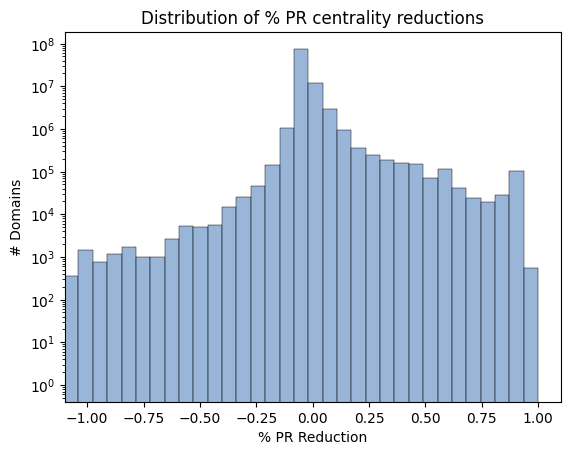

In [89]:
import seaborn as sns
df_inter = pre_rankings.merge(right=post_rankings, on='url', how='inner')
df_inter['orig_pr'] = pd.to_numeric(df_inter['orig_pr'], errors='coerce')
df_inter['inter_pr'] = pd.to_numeric(df_inter['inter_pr'], errors='coerce')
df_inter['diff'] = (df_inter['orig_pr'] - df_inter['inter_pr']) / df_inter['orig_pr']
df_inter['increase'] = -df_inter['diff']
sub_range = df_inter[df_inter['increase']<1.1]
sns.histplot(data=sub_range, x='increase', color='#779ECB', edgecolor='black', bins=50)
plt.xlim((-1.1,1.1))
plt.yscale('log')
plt.title('Distribution of % PR centrality changes')
plt.xlabel('% PR Increase')
plt.ylabel('# Domains')
plt.savefig('../fig/pr_reduction_distribution.png', bbox_inches='tight', dpi=300)

In [93]:
after_multi_file="/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/output/ls_multi_domain_atr/ls_multi_domain_atr-ranks.txt"
post_multi_rankings = pd.read_csv(after_multi_file, sep='\t', names=cc_rank_cols)[["url", "pagerank_centrality"]]
post_multi_rankings.columns=["url", "inter_pr"]
post_multi_rankings = post_multi_rankings.drop(post_multi_rankings.index[0])

/tmp/ipykernel_1635485/505153547.py:2: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  post_multi_rankings = pd.read_csv(after_multi_file, sep='\t', names=cc_rank_cols)[["url", "pagerank_centrality"]]


In [94]:
df_multi_inter = pre_rankings.merge(right=post_multi_rankings, on='url', how='inner')
df_multi_inter['orig_pr'] = pd.to_numeric(df_multi_inter['orig_pr'], errors='coerce')
df_multi_inter['inter_pr'] = pd.to_numeric(df_multi_inter['inter_pr'], errors='coerce')
df_multi_inter['diff'] = (df_multi_inter['orig_pr'] - df_multi_inter['inter_pr']) / df_multi_inter['orig_pr']

Text(0, 0.5, '# Domains')

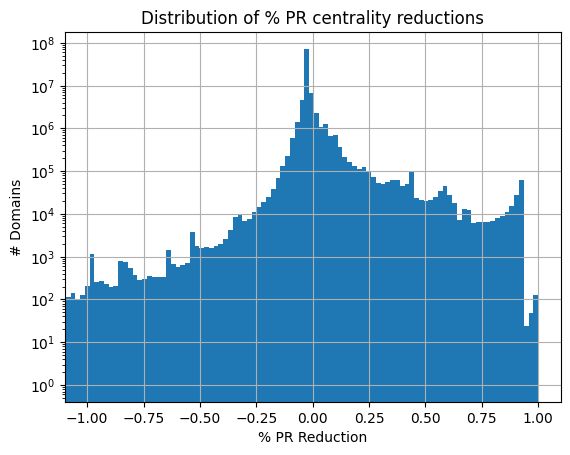

In [95]:
df_multi_inter['diff'].hist(bins=300)
plt.xlim((-1.1,1.1))
plt.yscale('log')
plt.title('Distribution of % PR centrality reductions')
plt.xlabel('% PR Reduction')
plt.ylabel('# Domains')
# plt.savefig('../fig/pr_reduction_distribution.png', bbox_inches='tight', dpi=300)

In [115]:
ls_reduction = df_inter[df_inter['diff'].abs() < 0.50].count()['url']
ls_multi_reduction = df_multi_inter[df_multi_inter['diff'].abs() < 0.50].count()['url']
num_domains = df_inter.count()['url']
print(num_domains - ls_reduction)
print(num_domains - ls_multi_reduction)
print(1 - ((num_domains - ls_multi_reduction) / float(num_domains - ls_reduction)))

419460
405083
0.03427502026414919


In [111]:
num_domains - ls_reduction

9263502

In [4]:
df_inter[(df_inter['orig_pr'] > 1e-7) & (df_inter['diff'] > 0.5)].count()# & (df_inter['diff'] < 0.9)]

url         7033
orig_pr     7033
inter_pr    7033
diff        7033
dtype: int64

In [7]:
df_biggest_losers = df_inter[(df_inter['orig_pr'] > 1e-7) & (df_inter['diff'] > 0.5)]
df_biggest_losers['url'] = df_biggest_losers['url'].apply(reverse_url)
df_biggest_losers.to_csv('biggest_losers_rank.csv', index=False)

/tmp/ipykernel_1635485/446843029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biggest_losers['url'] = df_biggest_losers['url'].apply(reverse_url)


In [60]:
df_news_downranked = df_inter[(df_inter['diff'] > 0.25) & (df_inter['url'].str.contains('news'))]

In [65]:
df_news_downranked_big = df_news_downranked[(df_news_downranked['orig_pr'] > 1e-7)]
df_news_downranked_big['url'].apply(reverse_url).to_csv('biggest_news_losers.csv', index=False)
df_news_downranked_big.count()

url         436
orig_pr     436
inter_pr    436
diff        436
dtype: int64

## ATR Score & Link Scheme Analysis

In [ ]:
domain_labels = pd.read_csv('../../data/attributes.csv')[['url', 'label']]
atr_discovered_urls = pd.read_csv('data/preference_vectors/domain_lists/link_scheme_atr_domains.txt', names=['url'])
atr_discovered_urls['url'] = atr_discovered_urls['url'].apply(reverse_url)
atr_urls_overlap = atr_discovered_urls.merge(right=domain_labels[['url', 'label']], on='url', how='inner')
atr_urls_overlap.groupby('label').count()

,url
label,
1,91
3,265
4,279
5,823
6,12


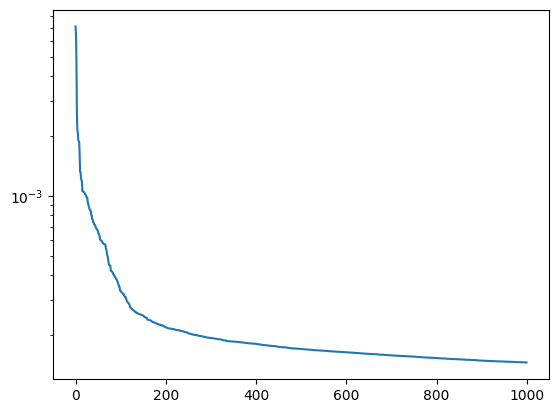

In [ ]:
import matplotlib.pyplot as plt
str_discovered_ranks = pd.read_csv('output/exp-ls-atr-discover-top.out.sorted', sep='\t', names=cc_rank_cols).head(1000)
plt.plot(str_discovered_ranks['pagerank_centrality'])
plt.yscale('log')

In [ ]:
str_discovered_ranks.head(100)

,harmonic_rank,harmonic_centrality,pagerank_rank,pagerank_centrality,url,a
0,76468047,0.000000e+00,1,0.006386,com.blogspot,4923095
1,66504102,1.389359e-31,2,0.005737,com.wordpress,4611551
2,96375303,0.000000e+00,3,0.005291,com.webranksite,1
3,23485615,1.534193e-01,4,0.002518,com.kingranks,1
4,63902281,1.997964e-22,5,0.002098,com.articlement,1
...,...,...,...,...,...,...
95,66918829,5.370093e-33,96,0.000898,com.healingfoodreference,1
96,106774200,0.000000e+00,97,0.000897,net.callmestormy,1
97,186187361,-6.117392e+32,98,0.000897,com.scaredmonkeys,1
98,180068512,-1.002780e+11,99,0.000897,com.proseoarticles,1


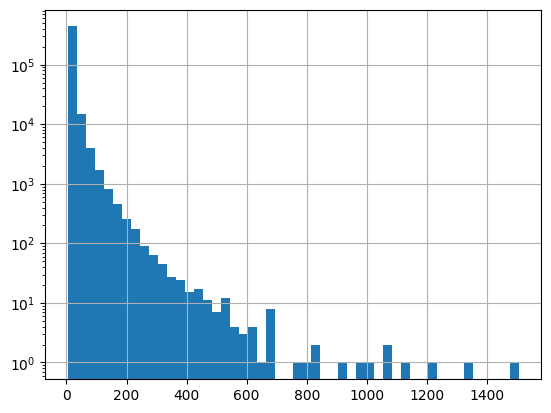

In [ ]:
ls_counts = pd.read_csv('/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/data/preference_vectors/domain_lists/cc_link_scheme_domains.txt.domains', sep=' ', names=['url','count'])
ls_counts['count'].hist(bins=50)
plt.yscale('log')
